In [1]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.preprocessing import QuantileTransformer
plt.rc("font", family = "Malgun Gothic")
plt.rc("axes", unicode_minus = False)
plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

# Train EDA

In [2]:
base_dir = 'data'

with open(os.path.join(base_dir,'train.json'),encoding='utf-8') as f:
    train = json.load(f)
    
train_df = pd.DataFrame(train)
train_df.head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000



## Train.tags

- 1. 결측치 확인
- 2. 모든 tag의 가짓수와 빈도수 ==> 중복제거 및 word vector로 변환할 내용 파악
- 3. 자연어 처리, 감성 분석 고민 

### Train.tags 결측치 확인

In [3]:
train_df[['tags']].isna().sum()

tags    0
dtype: int64

### Train.tags 단어별 빈도수

In [4]:
tag_total = []

train_df['tags'].map(lambda x : tag_total.extend(x))

tag_count = collections.Counter(tag_total)

tag_count_df = pd.DataFrame.from_dict(tag_count, orient='index').sort_values(by=0,ascending=False)

tag_count_df.columns = ['Count']

In [5]:
tag_count_df.describe() # 왜도

,Count
count,29160.000000
mean,16.335082
std,247.011075
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,16465.000000


In [6]:
tag_count_df

,Count
기분전환,16465
감성,11417
휴식,11215
발라드,10796
잔잔한,10218
...,...
섹시한분위기,1
퓨젼재즈,1
ThankYouLord,1
드렁크타이거,1


## Train.id
- Train.id 중복확인

### Train.id 중복확인

In [7]:
len(train_df) == len(train_df['id'].unique())

True

## Train.plylst_title
- 결측치 확인
- 자연어처리 가능성

###  Train.plylst_title 결측치 확인

In [8]:
train_df[['plylst_title']].isna().sum()

plylst_title    0
dtype: int64

## Train.songs
- 빈도수 탐색 해가지고 songs 데이터에 빈도를 넣을 수도 빈도가 높은 노래는 대부분 다 좋아하지 않을까? ==> songs.count 컬럼 도입?
- 플레이리스트 별 포함된 노래가짓수 ==> 노래 가짓수가 많으면 아무래도 노래가 골고루 들어있지 않을까? ==> playlist.length 컬럼 도입?
- 플레이 리스트 안에 중복된 노래는 없나?
- 겹치는 노래가 많은 플레이리스트 일수록 비슷한 취향을 저격할 것

### Train.songs 노래별 등장 빈도수 분석
- song.json과 join 필요

In [9]:
songs_count = []
train_df['songs'].map(lambda x : songs_count.extend(x))
songs_count = collections.Counter(songs_count)
songs_count_df = pd.DataFrame.from_dict(songs_count,orient='index')
songs_count_df = songs_count_df.sort_values(by=0,ascending=False)
songs_count_df.columns = ['Count']

In [10]:
songs_count_df
# 성향이 마이너한 곡들을 담은 플리가 많다

,Count
144663,2175
116573,2121
357367,1981
366786,1919
654757,1647
...,...
255114,1
385743,1
608019,1
324450,1


In [11]:
songs_count_df.describe()

,Count
count,615142.000000
mean,8.592928
std,39.481912
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,2175.000000


### Train.songs 플레이리스트 별 포함된 노래수

In [12]:
train_df['playlist_length'] = train_df['songs'].map(lambda x : len(x))
train_df.head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date,playlist_length
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,19
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,42
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,28


### Train.songs 중복곡 검사

In [13]:
test_duplicate = train_df['songs'].map(lambda x : len(x) == len(set(x)))
test_duplicate.unique()

array([ True])

## Train.like_cnt 
- 좋아요 수와 플레이리스트 길이의 상관관계 ==> 많은 노래가 수록될수록 보편적으로 좋아할까?
- tag가 tag된 횟수 / tag의 길이와 좋아요 수와의 상관관계
- song이 포함된 횟수 / songs의 길이와 좋아요의 상관관계
- tag 갯수가 많을 수록 좋아요가 많지 않을까?

In [14]:
qt = QuantileTransformer(n_quantiles=100000,output_distribution='normal')

train_df['normal_cnt'] = qt.fit_transform(train_df['like_cnt'].values.reshape(-1,1))

# playlist_length도 정규화하기

###  Train.like_cnt 좋아요 수와 플레이리스트 길이의 상관관계

In [15]:
# 그냥 count
train_df[['like_cnt','playlist_length']].corr()

,like_cnt,playlist_length
like_cnt,1.000000,0.149828
playlist_length,0.149828,1.000000


In [16]:
# 정규화된 count
train_df[['normal_cnt','playlist_length']].corr()

,normal_cnt,playlist_length
normal_cnt,1.000000,0.205865
playlist_length,0.205865,1.000000


<AxesSubplot:xlabel='playlist_length', ylabel='like_cnt'>

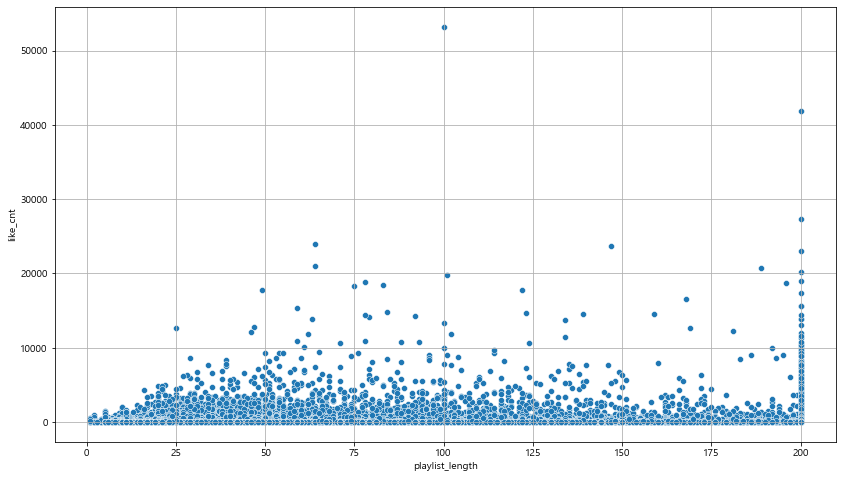

In [17]:
sns.scatterplot(y='like_cnt',x='playlist_length',data = train_df[['like_cnt','playlist_length']])

###  Train.like_cnt tag가 tag된 횟수 / tag의 길이와 좋아요 수와의 상관관계

In [18]:
def tag_sum(x):
    temp = 0
    for value in x:
        temp = temp + tag_count[value]
    return temp / len(x)        

train_df['tag_mean'] =  train_df['tags'].map(tag_sum)

In [19]:
# 그냥 count
train_df[['tag_mean','like_cnt']].corr()

,tag_mean,like_cnt
tag_mean,1.000000,-0.003329
like_cnt,-0.003329,1.000000


In [20]:
# 정규화된 count
train_df[['tag_mean','normal_cnt']].corr()

,tag_mean,normal_cnt
tag_mean,1.000000,-0.036783
normal_cnt,-0.036783,1.000000


<AxesSubplot:xlabel='tag_mean', ylabel='like_cnt'>

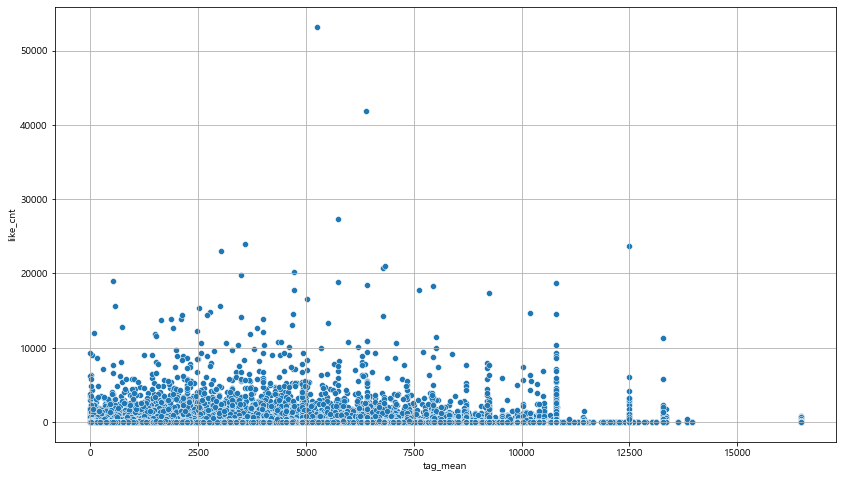

In [21]:
sns.scatterplot(y='like_cnt',x='tag_mean',data = train_df[['tag_mean','like_cnt']])
# 좋아요를 뭔가 계층적으로 나눠서 하면 의미가 생길지도? 4분위수 8분위수 혹은 10단위 

### Train.like_cnt song이 포함된 횟수 / songs의 길이와 좋아요의 상관관계

In [22]:
def songs_sum(x):
    temp = 0
    for value in x:
        temp = temp + songs_count[value]
    return temp / len(x)        

train_df['songs_mean'] = train_df['songs'].map(songs_sum)

# 좋아요를 뭔가 계층적으로 나눠서 하면 의미가 생길지도? 4분위수 8분위수 혹은 10단위 

In [23]:
# 그냥 count
train_df[['songs_mean','like_cnt']].corr()

,songs_mean,like_cnt
songs_mean,1.000000,-0.040487
like_cnt,-0.040487,1.000000


In [24]:
# 정규화된 count
train_df[['songs_mean','normal_cnt']].corr()

,songs_mean,normal_cnt
songs_mean,1.000000,-0.116768
normal_cnt,-0.116768,1.000000


애초에 좋아요 데이터 왜도가 너무 높아서 상관관계가 제대로 안잡히는것 같기도 ==> 데이터 변환 필요

In [25]:
train_df['like_cnt'].describe()

count    115071.000000
mean         95.197687
std         560.653757
min           0.000000
25%           2.000000
50%           7.000000
75%          24.000000
max       53211.000000
Name: like_cnt, dtype: float64

<AxesSubplot:xlabel='songs_mean', ylabel='like_cnt'>

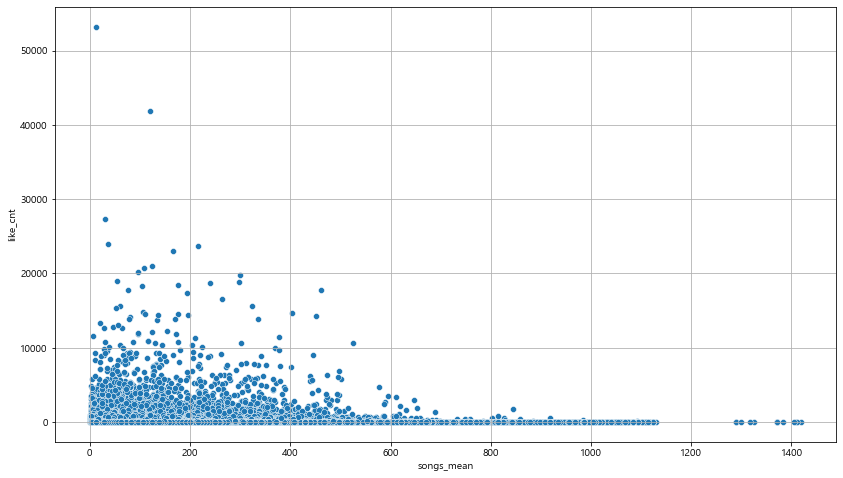

In [26]:
sns.scatterplot(y='like_cnt',x='songs_mean',data = train_df[['songs_mean','like_cnt']])

### Train.like_cnt와 tag의 숫자와의 상관관계

In [27]:
train_df['tags_cnt'] = train_df['tags'].map(lambda x : len(x))

In [28]:
train_df[['tags_cnt','like_cnt']].corr()

,tags_cnt,like_cnt
tags_cnt,1.000000,0.066963
like_cnt,0.066963,1.000000


In [29]:
train_df[['tags_cnt','normal_cnt']].corr()

,tags_cnt,normal_cnt
tags_cnt,1.000000,0.160804
normal_cnt,0.160804,1.000000


## Train.updt_date

- 최신 업데이트된 플레이리스트 일수록 최신곡을 담고있을것 같다. (조인 필요)
- 최신 업데이트된 플레이리스트 일수록 좋아요 수가 많을 것 같다.

### Train.updt_date와 좋아요 수의 상관관계

In [30]:
train_df['updt_date'] = pd.to_datetime(train_df['updt_date'])

In [31]:
def to_date_2004(x):
    year = (x.year - 2004)*365
    month = (x.month)*30
    date = x.day
    
    return year+month+date


train_df['updt_date_to_date'] = train_df['updt_date'].map(to_date_2004)

# 좋아요를 뭔가 계층적으로 나눠서 하면 의미가 생길지도? 4분위수 8분위수 혹은 10단위 

In [32]:
train_df[['updt_date_to_date','like_cnt']].corr()

,updt_date_to_date,like_cnt
updt_date_to_date,1.000000,0.036565
like_cnt,0.036565,1.000000


In [33]:
train_df[['updt_date_to_date','normal_cnt']].corr()

,updt_date_to_date,normal_cnt
updt_date_to_date,1.00000,0.00358
normal_cnt,0.00358,1.00000


# Song Meta EDA

In [34]:
with open(os.path.join(base_dir,'song_meta.json'),encoding='utf-8') as f:
    song_meta = json.load(f)
    
song_meta_df = pd.DataFrame(song_meta)
song_meta_df.head(3)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2


In [35]:
song_meta_df.columns = ['장르소분류list','등록일','앨범명','앨범id','가수id_list','곡명','장르대분류list','가수명list','곡id']
song_meta_df.head(3)

,장르소분류list,등록일,앨범명,앨범id,가수id_list,곡명,장르대분류list,가수명list,곡id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2


In [36]:
train_df.head(3)

,tags,id,plylst_title,songs,like_cnt,updt_date,playlist_length,normal_cnt,tag_mean,songs_mean,tags_cnt,updt_date_to_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19,19,1.068083,4007.0,14.736842,1,3664
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42,42,-1.103747,5549.5,169.761905,2,4012
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34,28,0.496976,6537.0,68.571429,2,5013


In [37]:
with open(os.path.join(base_dir,'genre_gn_all.json'),encoding='utf-8') as f:
    genre = json.load(f)

In [38]:
train_column = ['태그','플리아이디','플리제목',
                              '좋아요 횟수','갱신일','플리곡수',
                              '정규화_좋아요','태그_좋아요_평균',
                              '곡_좋아요_평균','태그수','갱신일_날짜']
train_column.extend(song_meta_df.columns)

train_ws_df = pd.DataFrame(columns=train_column)

In [39]:
count_as_index = 0

def song_merge(x):
    
    global count_as_index
    row_list = train_df.loc[count_as_index,train_df.columns.difference(['songs'])].values
    
    return 0

train_df['songs'].map(song_merge)

0         0
1         0
2         0
3         0
4         0
         ..
115066    0
115067    0
115068    0
115069    0
115070    0
Name: songs, Length: 115071, dtype: int64

## SongMeta.장르소분류list
